In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')
mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms

from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix

torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
import logger
from callbacks.cmatrix import CMatrix
from callbacks.binhist import BinHist

### Generate training and testing data

In [3]:
# generate test data
data, labels = make_blobs(1200, 2, 2)
labels = labels.reshape(-1, 1)

# divide into train set and test set
train_data, train_labels = data[:1000], labels[:1000]
test_data, test_labels = data[1000:], labels[1000:]

# normalize
test_data = (test_data-train_data.mean(0))/train_data.std(0)
train_data = (train_data-train_data.mean(0))/train_data.std(0)

# convert to tensor
test_data, test_labels = torch.Tensor(test_data), torch.Tensor(test_labels)
train_data, train_labels = torch.Tensor(train_data), torch.Tensor(train_labels)

In [4]:
# dataloader
batch_size = 32
train_loader = DataLoader(list(zip(train_data, train_labels)), batch_size)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size)

Text(0.5, 1.0, 'Preprocessed data')

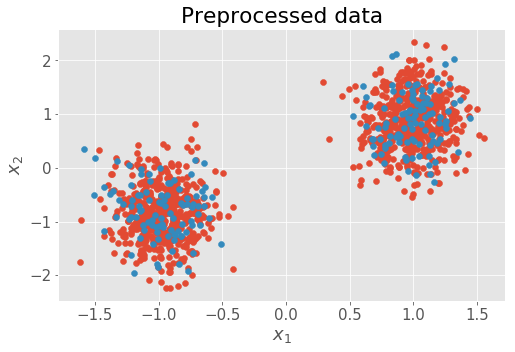

In [5]:
plt.figure()
plt.scatter(*train_data.numpy().T, label='Training')
plt.scatter(*test_data.numpy().T, label='Testing')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Preprocessed data')

### Define network and callback objects

In [6]:
# Define small network
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.relu_(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [7]:
# model, loss function, optimizer
model = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# lookback
cmatrix = CMatrix(labels=('Noise', 'Signal'))
binhist = BinHist(labels=('Noise', 'Signal'))

### Start training

In [8]:

class BinHist:
    '''Binary score histogram '''
    
    def __init__(self, bins=np.linspace(0., 1., 21), labels=None):
        self.score0 = np.zeros(len(bins)-1)
        self.score1 = np.zeros(len(bins)-1)
        self.bins = bins
        self.labels = labels

    def update(self, y_pred, y_true):
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.data.cpu().numpy()
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.data.cpu().numpy()

        score0, _ = np.histogram(y_pred[(y_true == 0)], self.bins)
        score1, _ = np.histogram(y_pred[(y_true == 1)], self.bins)
        self.score0 += score0
        self.score1 += score1
            
    def reset(self):
        self.score0 = np.zeros(len(self.bins)-1)
        self.score1 = np.zeros(len(self.bins)-1)
        
    def plot(self, both=False):
        ''' Plot histogram '''
        
        fig, ax = plt.subplots(1)
        bc = .5*(binhist.bins[1:]+binhist.bins[:-1]) # bin center
        if not both:
            ax.hist(bc, self.bins, weights=self.score0, 
                    edgecolor='k', alpha=0.5, label=self.labels[0])
            ax.hist(bc, self.bins, weights=self.score1, 
                    edgecolor='k', alpha=0.5, label=self.labels[1])
        else:
            ax.hist(bc, self.bins, weights=self.score0+self.score1,
                    edgecolor='k', alpha=0.5, label='{} + {}'.format(*self.labels))
        ax.set(xlabel='Score', ylabel='Frequency')
        ax.legend()
        return fig, ax

In [9]:
def test():    
    model.eval()
    
    # Reset callbacks
    cmatrix.reset()
    binhist.reset()
    
    loss = 0.
    with torch.no_grad():
        for n_batch, (data, targets) in enumerate(test_loader):
            scores = model(data)
            loss += criterion(scores, targets)
            pred = scores.round()
            cmatrix.update(pred, targets)
            binhist.update(pred, targets)
        loss /= len(test_loader.dataset)
    return loss

In [10]:
num_epochs = 10
num_batches = len(train_loader)

# define logger
log = logger.ClassifierLogger(
    model_name='shallow-net', data_name='sklearn-blobs')

# start training
for epoch in range(num_epochs):
    train_loss = 0.
    n_data = 0.
    for n_batch, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Train on batch
        model.train()
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()
        
        # Update train loss
        train_loss += loss
        n_data += len(data)
    
        # Log error and Display progress
        if n_batch % 10 == 0:
            
            train_loss_display = train_loss/n_data
            
            # Test on test dataset
            test_loss_display = test()
            
            # log error
            log.log_metric(
                train_loss_display, test_loss_display, 'error',
                epoch, n_batch, num_batches)
            
            # log binary histogram and confusion matrices
            log.save_binhist(binhist, epoch, n_batch)
            log.save_cmatrix(cmatrix, epoch, n_batch)
            
            # display status
            log.display_status(
                epoch, num_epochs, n_batch, num_batches,
                train_loss_display, test_loss_display, 'loss'
            )
            
            # log model every epochs
            log.save_models(model, epoch, n_batch)

Epoch: [0/10], Batch Num: [0/32]
Train loss: 0.0293, Test loss: 0.0299
Epoch: [0/10], Batch Num: [10/32]
Train loss: 0.0272, Test loss: 0.0293
Epoch: [0/10], Batch Num: [20/32]
Train loss: 0.0262, Test loss: 0.0287
Epoch: [0/10], Batch Num: [30/32]
Train loss: 0.0262, Test loss: 0.0280
Epoch: [1/10], Batch Num: [0/32]
Train loss: 0.0270, Test loss: 0.0279
Epoch: [1/10], Batch Num: [10/32]
Train loss: 0.0253, Test loss: 0.0272
Epoch: [1/10], Batch Num: [20/32]
Train loss: 0.0244, Test loss: 0.0266
Epoch: [1/10], Batch Num: [30/32]
Train loss: 0.0244, Test loss: 0.0259
Epoch: [2/10], Batch Num: [0/32]
Train loss: 0.0247, Test loss: 0.0258
Epoch: [2/10], Batch Num: [10/32]
Train loss: 0.0234, Test loss: 0.0251
Epoch: [2/10], Batch Num: [20/32]
Train loss: 0.0226, Test loss: 0.0245
Epoch: [2/10], Batch Num: [30/32]
Train loss: 0.0225, Test loss: 0.0238
Epoch: [3/10], Batch Num: [0/32]
Train loss: 0.0224, Test loss: 0.0237
Epoch: [3/10], Batch Num: [10/32]
Train loss: 0.0214, Test loss: 0.0